# PA2.2 Part C - Hidden Markov Model (HMM) Based Multi-Step Time Series Forecasting with Covariates

### Introduction

In this notebook, you will be utilizing the HMMLearn library for weather forecasting.

### Terminology

**Covariates:** are time series that we are not trying to predict directly, but they assist us in predicting the time series that we are trying to predict (think of them as just extra pieces of information that we think might affect what we're trying to understand or predict). They help us make better predictions by considering more factors that could be important. For example, if we're trying to predict how much someone will spend on groceries in a month, we might consider their income, family size, and where they live as covariates. These extra details give us a clearer picture and make our predictions more accurate.

**Multi-Step Forecasting:** refers to the process of predicting multiple future values in a time series. Unlike single-step forecasting, which predicts the next immediate value, multi-step forecasting aims to forecast several steps ahead, ranging from a few time periods to potentially hundreds or more into the future. This type of forecasting is crucial in various domains where understanding future conditions over a longer horizon can significantly impact decision-making and planning, in our case, weather prediction.

### Instructions

- Follow along with the notebook, filling out the necessary code where instructed.

- <span style="color: red;">Read the Submission Instructions, Plagiarism Policy, and Late Days Policy in the attached PDF.</span>

- <span style="color: red;">Make sure to run all cells for credit.</span>

- <span style="color: red;">Do not remove any pre-written code.</span>

- <span style="color: red;">You must attempt all parts.</span>

For this notebook, in addition to standard libraries i.e. `numpy`, `nltk`, `collections` and `tqdm`, you are permitted to incorporate supplementary libraries, but it is strongly advised to restrict their inclusion to a minimum. However, other HMM toolkits or libraries are strictly prohibited.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

from hmmlearn.hmm import GaussianHMM, GMMHMM
from hmmlearn.vhmm import VariationalGaussianHMM

import logging
logging.getLogger("hmmlearn").setLevel("CRITICAL")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

#!pip install meteostat
from meteostat import Point, Daily

### Preparing our Training and Validation Data

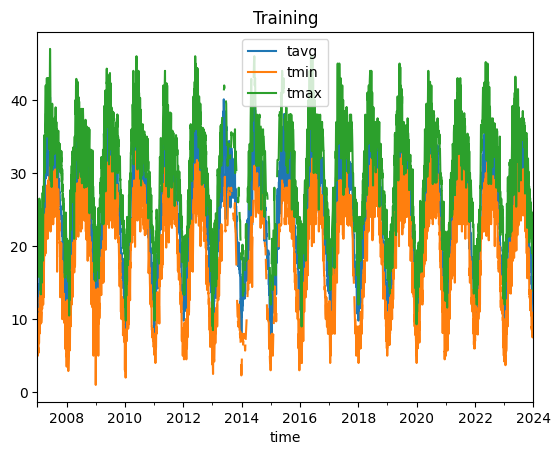

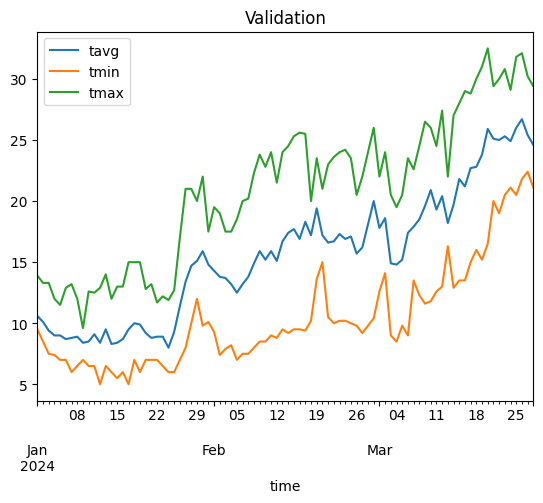

In [2]:
# Creating Point for Lahore, PK
location = Point(31.558, 74.3507, 216)

train_data = Daily(location, start = datetime(2007, 1, 1), end = datetime(2024, 1, 1)).normalize().interpolate().fetch()
val_data = Daily(location, start = datetime(2024, 1, 1), end = datetime.today() - timedelta(days=1)).normalize().interpolate().fetch()

for data, label in zip([train_data, val_data], ['Training','Validation']):
    # Plot line chart including average, minimum and maximum temperature
    data.plot(y=['tavg', 'tmin', 'tmax'])
    plt.title(label)
    plt.show()

Follow this [link](https://dev.meteostat.net/python/daily.html#data-structure) to know more about the available features. 

The features we are interested in are:
* __tavg__ (average air temperature in °C)


*__Covariates__*:
* __tmin__ (minimum air temperature in °C)
* __tmax__ (maximum air temperature in °C)

In [3]:
train_data = train_data[['tavg', 'tmin', 'tmax']]
val_data = val_data[['tavg', 'tmin', 'tmax']]

In [4]:
# ini= train_data.iloc[-1:].values[0]
# print(ini * 0.5)
# print(np.multiply([1,2,3],[2,5,3]))
print(np.add(1, [1,2,3]))

[2 3 4]


In [5]:
#Since the data contains nans, we'll also interpolate it
train_data = train_data.interpolate(method='polynomial', order = 9).round(2) #9 might've been an overkill but why not lol
val_data = val_data.interpolate(method='polynomial', order = 9).round(2)

For Multi-Step Forecasting, there are two main approaches:
1. __Static Forecasting:__ This approach uses a single model to make the first future prediction, and then uses the actual value of the lagged dependent variable (if it is available) instead of the predicted/forecasted value. And corrects itself to make the next prediction. __This can be used for both validation dataset and for multi-step forecasting purposes__

2. __Dynamic Forecasting__: In this approach, involves developing one model that is capable of predicting the entire forecast sequence in a one-shot manner.
As an example, In the case of predicting the temperature for the next fifteen days, we would develop one model and use it to predict the next fifteen days as one operation.  __This can be used for both validation dataset and for multi-step forecasting purposes__

Your task is to implement the following:
1. Recursive Method.
2. Multi Output Method.

### WeatherPredictorHMM Class
The __WeatherPredictorHMM__ Class contains the following methods:

1. `__init__(self, forecast_method = 'static')`: creates the __WeatherPredictorHMM__ objects and prepares it for training, contains:
    - `self.train data` and `self.val_data`, consisting of our preprocessed time series data.
    - `self.eval_type = None`, the data to evaluate on, either `val` or `forecast`.
    - `self.hist_data = None`, the data to train the model on (can also be called history). Would be different depending on `self.eval_type`.
    - `self.hist_data_pct_change = None`, `converting the training data to percentage changes i.e. the percentage difference between 2 consecutive values.
    - `self.forecast_method`, the forecasting method for future values, either `static` or `dynamic`.
    - `self.forecast_dates`, the dates for which values has to be forecasted if `self.forecast_method = dynamic`

2. `set_eval(self, eval_type='val')`: initializes the `self.eval_type`, `self.hist_data` and `self.hist_data_pct_change`, in the following manner:
    - If `eval_type = val`, then  `self.hist_data` is our training data itself and `self.hist_data_pct_change` is the dataframe (with the the first row dropped)  \
    containing the percentage changes between two consecutive dataframe rows.
    -If `eval_type = forecast`, then  `self.hist_data` is our training data + validation data (since we are now interested in the 15 day forecast outside our data)  \
    and `self.hist_data_pct_change` is the dataframe for the now combined `self.hist_data` (with the the first row dropped)  \
    containing the percentage changes between two consecutive dataframe rows.

3. `static_forecasting(self, model_to_use = None)`: __(To Be Implemented)__ performs static forecasting, the `model_to_use` is an additional __optional__ parameter  \
if you want to provide your own model when for example doing a grid search over model parameters. Program flow is:
    - Predicting all the percentage changes for the whole length of evaluation data __(relevant function here is `model.sample()`)__
    - Get the actual value of the previous timestep and incorporate the percentage change into it to get the next predicted value.
    - Returns an array of predicted values.
    
4. `dynamic_forecasting(self, model_to_use = None, is_train = False)`: __(To Be Implemented)__ performs dynamic forecasting by using previous predictions at each step accepts an optional model_to_use parameter for cases where a specific model configuration is desired (e.g., during parameter tuning or cross-validation). The is_train flag indicates whether the forecasting is being done in a training context (i.e., using training data to predict the next steps and comparing with validation data) or in a genuine forecasting context (i.e., training on both the training + validation data and predicting future values outside the available data). The process flow is as follows:
    - If `is_train = True` or `self.eval_type = 'val`, it predicts percentage changes based on the length of the validation data minus one (since the first prediction is based on the last historical data point).
    - If `is_train = False` and `self.eval_type = "forecast"`, it predicts percentage changes for the duration covered by self.forecast_dates.
    The method begins by predicting the next value based on the last historical data point (for training/validation) or the last validation data point (for forecasting).
    -Returns an array of predicted values.

5. `train(self)`:  __(To Be Implemented)__ Trains the Hidden Markov Model (HMM) on historical data to predict future weather conditions.
    - Feel free to modify function signature and return values.
    - Do not change the function name.
Optionally, you can also perform a grid search. Hence, you can iterate a range of n_components to find the optimal configuration for the model by minimizing the Symmetric Mean Absolute Percentage Error (SMAPE) loss. In this case, make sure to add an option for both `__STATIC__` and `__DYNAMIC__` forecasting for generating predictions.

6. `predict(self, return_loss = False)`:  __(Can Be Modified)__ Generates weather predictions using the trained model. This method decides between static and dynamic forecasting based on the forecast_method attribute. Optionally, it can return the SMAPE loss of the predictions if return_loss is set to True (Note that loss calculation is not supported for the forecast phase). The method:
    - Uses static_forecasting or dynamic_forecasting to generate predictions.
    - Returns the array of predicted values.
    - Also, returns SMAPE loss if `return_loss = True` and `eval_type != "forecast"`.
    - Feel free to modify function signature and return values.
    - Do not change the function name.

7. `plot_predictions(self, predictions = None)`: Visualizes the weather predictions alongside historical and validation data. This method requires a set of predictions and uses matplotlib to plot the data. It:
    - Checks if a model is trained and predictions are provided. If not, raises an appropriate error.
    - Plots the last 60 days of historical data and validation data for temperature averages (tavg), minimums (tmin), and maximums (tmax).
    - Distinguishes between validation and forecasting phases by adjusting the data and predictions accordingly.
    - Highlights the transition from historical to predicted data and displays the plot with appropriate labels and titles.

In [91]:
import hmmlearn as hmm
class WeatherPredictorHMM():
    def __init__(self, forecast_method = "static"):
        self.model = None #Storing a single model for the t+1 prediction.
        self.train_data = train_data
        self.val_data = val_data
        self.eval_type = None
        self.hist_data = None
        self.hist_data_pct_change = None
        self.forecast_method = forecast_method
        self.forecast_dates = [np.datetime64('today') + np.timedelta64(x, 'D') for x in range(0, 15)]

        #----------------Add Any Additional Variables Here----------------


         #----------------Do Not Modify The Code Below This Line----------------

    def set_eval(self, eval_type = 'val'):
        if eval_type not in ['val', 'forecast']:
            raise ValueError("Invalid phase. Please provide a valid evaluation type: val, or forecast.")
        
        self.eval_type = eval_type
        self.hist_data = self.train_data
        self.hist_data_pct_change = self.hist_data.pct_change()[1:]
            
        if self.eval_type == "forecast":
            self.hist_data = pd.concat([self.train_data, self.val_data])
            self.hist_data_pct_change = self.hist_data.pct_change()[1:]

    def smape_multivariate(self, A, F): # We'll use Symmetric mean absolute percentage error to compare our predictions on the validation set        
        
        # Calculate SMAPE for each variable
        smapes = 100 / A.shape[0] * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)), axis=0)
        
        # Average SMAPEs across all variables
        return np.mean(smapes)
    

    def static_forecasting(self, model_to_use = None):
        
        predictions = []

        #----------------Add Your Code Here----------------
        if model_to_use == None:
            model = self.model 
        else:
            model = model_to_use

        pct_changes = model.sample(len(self.val_data))
        pct_changes = pct_changes[0]

        # Initial value is the last value from the historical data
        initial_value = self.hist_data.iloc[-1:].values[0]
        first_change = np.multiply(initial_value, np.add(1 , pct_changes[0]))
        predictions.append(first_change)

        val_data = self.val_data

        for i in range(len(val_data)-1):
            val_array = val_data.iloc[i].values
            change = np.multiply(val_array , np.add(1 , pct_changes[i+1]))
            predictions.append(change.copy())


        # raise NotImplementedError("You need to implement the static_forecasting method.")
        #----------------Do Not Modify The Code Below This Line----------------

        return np.array(predictions)
    
    def dynamic_forecasting(self, model_to_use = None, is_train = False):

        predictions = []
        model_to_use = self.model if model_to_use is None else model_to_use
        predictions = []

        #----------------Add Your Code Here----------------
        if is_train or self.eval_type == 'val':
            n_steps = len(self.val_data) - 1
        else:
            n_steps = len(self.forecast_dates)

        initial_value = np.array(self.hist_data.iloc[-1:].values[0])
        
        pct_changes = np.array(model_to_use.sample(len(self.val_data))[0])

        predicted_value = (initial_value * (1 + pct_changes[0]))
        predictions.append(predicted_value)
        
        for step in range(n_steps-1):
            # predicted_value = (predictions[step] * (1 + pct_change))
            change = predictions[step] * (1 + pct_changes[step+1])
            predictions.append(change.copy())
            
        # raise NotImplementedError("You need to implement the dynamic_forecasting method.")
        #----------------Do Not Modify The Code Below This Line----------------
        print(len(predictions))
        return np.array(predictions)
    
    def train(self):
        my_model = None

        #----------------Add Your Code Here----------------
        
        # train_data = self.train_data[['tavg', 'tmin', 'tmax']]
        self.model = GaussianHMM(n_components=10)
        self.model.fit(self.hist_data_pct_change)
        
        

        # raise NotImplementedError("You need to implement the train method.")
        #----------------Do Not Modify The Code Below This Line----------------
        
    def predict(self, return_loss = False):
        val_predictions = None

        if return_loss and self.eval_type == "forecast":
            raise ValueError("Cannot return loss for forecast phase. Bro/Sis, like how?")
        
        if self.forecast_method == "static":
            val_predictions = self.static_forecasting()
        elif self.forecast_method == "dynamic":
            val_predictions = self.dynamic_forecasting()
            
        if return_loss:
            return val_predictions, self.smape_multivariate(self.val_data, val_predictions)
        
        return val_predictions
    
    def plot_predictions(self, predictions = None):
        if self.model is None:
            raise NotImplementedError("Model is not trained.")
        
        if predictions is None:
            raise ValueError("Predictions not provided.")
                
        plot_history = self.hist_data[['tavg', 'tmin', 'tmax']]
        plot_current = self.val_data[['tavg', 'tmin', 'tmax']]
            
        _, ax = plt.subplots(figsize=(15, 5))
        
        plot_history.iloc[-60:].plot(ax = ax, kind = 'line', y = ['tavg', 'tmin', 'tmax'], color = ['midnightblue', 'sienna', 'darkgreen'], alpha=0.5)
        plt.axvline(x=plot_history.index[-1], color='0.4', linestyle= '--', label = 'Past 60 Days')

        if self.eval_type == "val":
            plot_current.plot(ax = ax, kind = 'line', y = ['tavg', 'tmin', 'tmax'], color = ['tab:blue', 'tab:orange', 'tab:green'], linewidth=2)
            plt.plot(plot_current.index[:], predictions[:, :3], label = ['tavg', 'tmin', 'tmax'], linestyle = '-.')
        
        else:
            init_val = plot_history.iloc[-1].values
            predictions = np.vstack([init_val, predictions])
            self.forecast_dates.insert(0, plot_history.index[-1])
            df_predictions = pd.DataFrame(predictions[:, :3], index= self.forecast_dates, columns=['tavg', 'tmin', 'tmax'])
            df_predictions.index = pd.to_datetime(df_predictions.index)
            
            df_predictions.plot(ax = ax, y = ['tavg', 'tmin', 'tmax'], color = ['tab:blue', 'tab:orange', 'tab:green'], linestyle = '-.')

        plt.title(f"Weather Prediction ({self.eval_type})")
        plt.xlabel("Date")
        plt.ylabel("Values")
        plt.legend()
        plt.grid(True)
        plt.show()

## Plot the following Forecast Graphs:
1. __Predictions on the val Set Using Static Method + SMAPE Loss__
2. __Predictions on the val Set Using Dynamic Method + SMAPE Loss__
3. __15 Day future forecast using Dynamic Method__

### Forecast Graph for val Set Using Static Method __[30 Marks]__

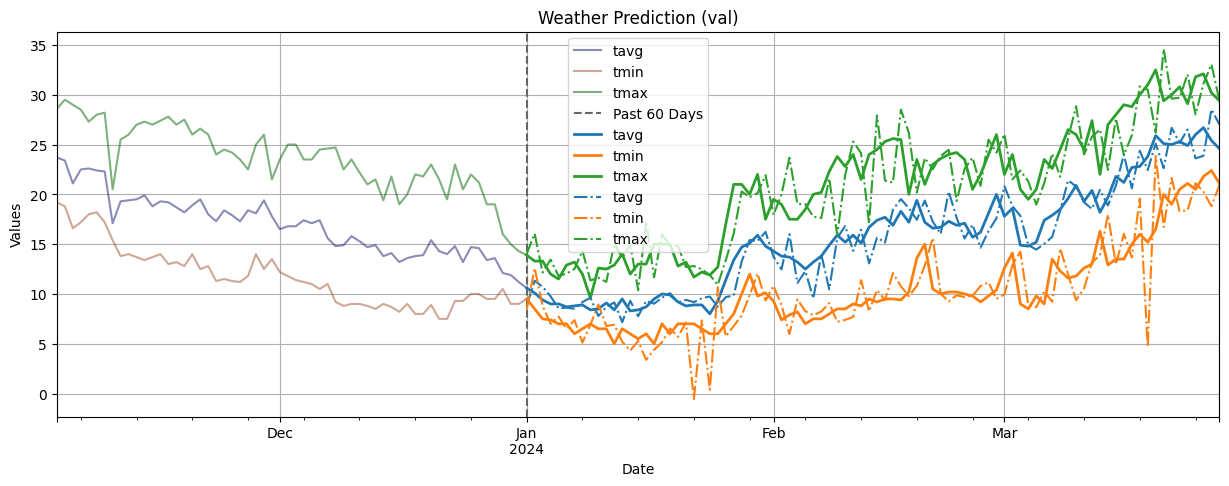

SMAPE LOSS:  13.851395085963054


In [65]:
my_HMM = WeatherPredictorHMM(forecast_method = "static")
my_HMM.set_eval('val')
my_HMM.train()
val_predictions, val_loss = my_HMM.predict(return_loss = True)
my_HMM.plot_predictions(predictions = val_predictions)
print("SMAPE LOSS: ", val_loss)

### Forecast Graph for val Set Using Dynamic Method __[30 Marks]__

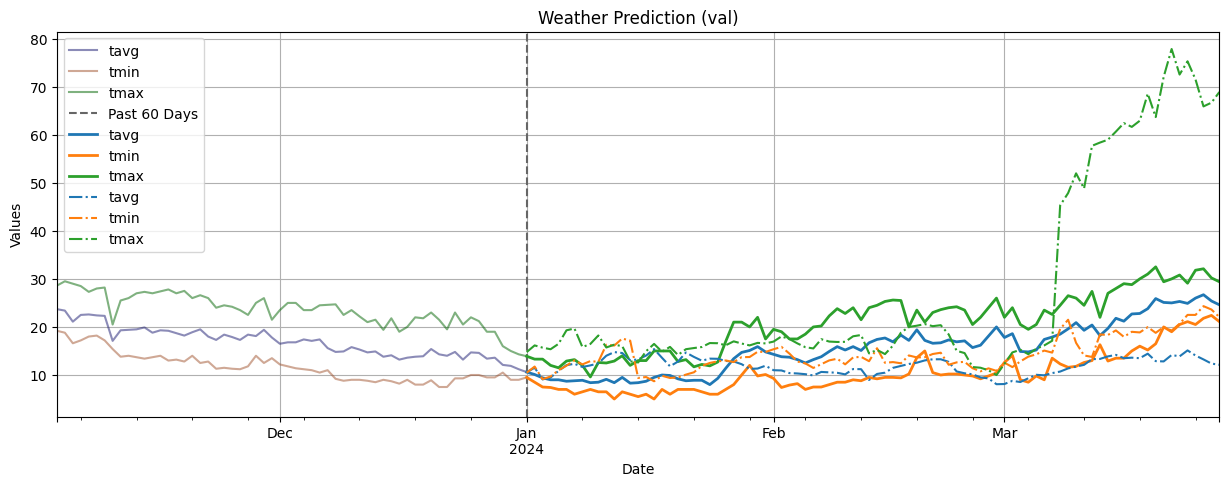

SMAPE LOSS:  38.107136538571204


In [87]:
my_HMM = WeatherPredictorHMM(forecast_method = "dynamic")
my_HMM.set_eval('val')
my_HMM.train()
val_predictions, val_loss = my_HMM.predict(return_loss = True)
my_HMM.plot_predictions(predictions = val_predictions)
print("SMAPE LOSS: ", val_loss)

In [90]:
print(len(val_predictions))


16


### 15 Day future forecast using Dynamic Method __[40 Marks]__

15


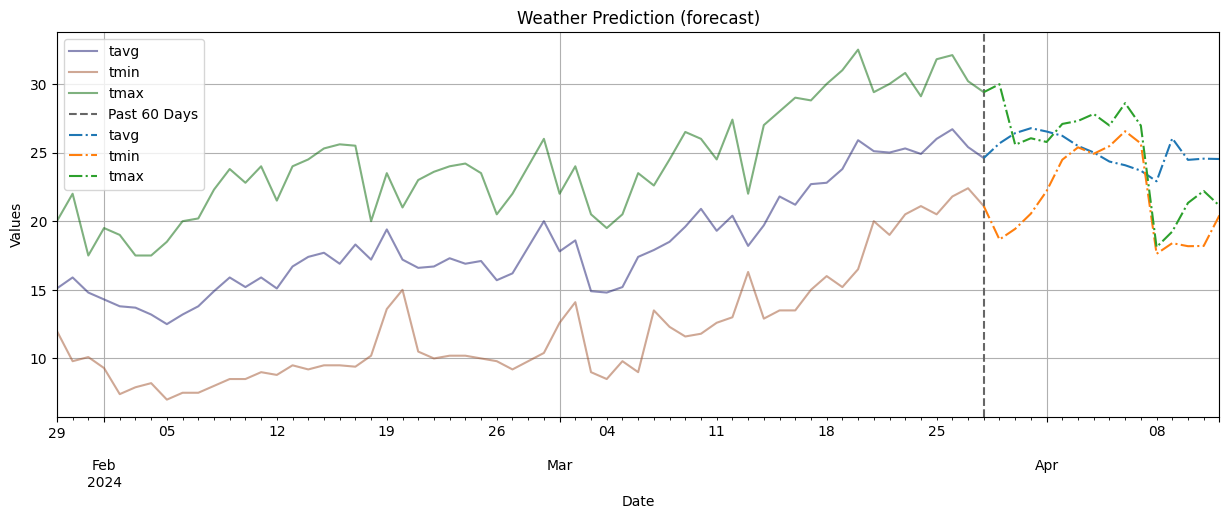

In [92]:
my_HMM = WeatherPredictorHMM(forecast_method = "dynamic")
my_HMM.set_eval('forecast')
my_HMM.train()
val_predictions = my_HMM.predict(return_loss = False)
my_HMM.plot_predictions(predictions = val_predictions)